## <center>Прогнозирование цен на автомобили с использованием метода k-ближайших соседей: Предикторы, число k, кросс-валидация </center>

                                                            Проект выполнил: Резвухин Д.И., февраль 2023 г.

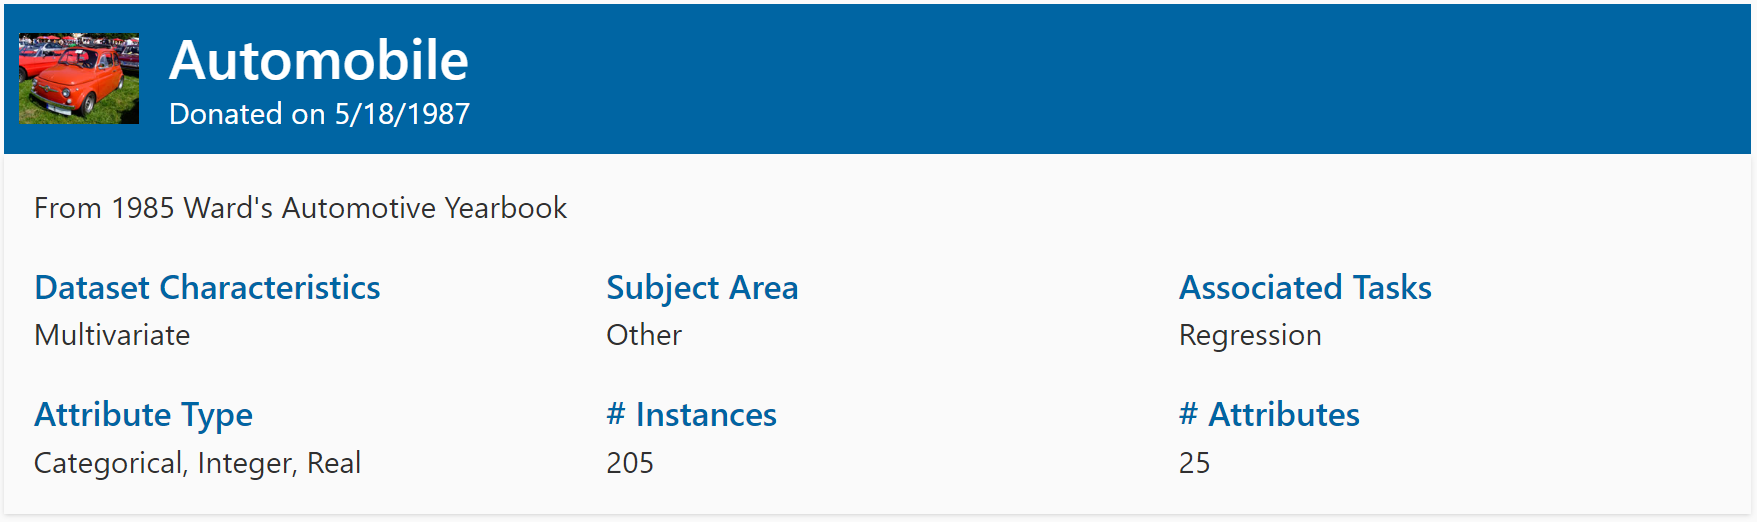

### Введение

В рамках реализации данного проекта мы будем работать с [датасетом 1985 года на UCI Machine Learning Depository](https://archive.ics.uci.edu/ml/datasets/automobile), который содержит информацию о различных автомобилях того времени. Этот датасет представляет собой данные по спецификации автомобиля с учетом различных характеристик (кузов, объем мотора, масса, расход топлива, разгон и др.). 

Цель проекта заключается в создании и обучении ML-алгоритма методом k-ближайших соседей, который будет предсказывать стоимость автомобиля на основе его характеристик. Мы попробуем различные комбинации числа соседей (`n_neighbors`) и предикторов, чтобы выяснить, какое сочетание минимизирует ошибку на тестовой выборке.

Ниже приводится словарь базы данных, в котором указаны возможные значения каждого признака.

1. symboling: -3, -2, -1, 0, 1, 2, 3.
2. normalized-losses: continuous from 65 to 256.
3. make:
alfa-romero, audi, bmw, chevrolet, dodge, honda,
isuzu, jaguar, mazda, mercedes-benz, mercury,
mitsubishi, nissan, peugot, plymouth, porsche,
renault, saab, subaru, toyota, volkswagen, volvo

4. fuel-type: diesel, gas.
5. aspiration: std, turbo.
6. num-of-doors: four, two.
7. body-style: hardtop, wagon, sedan, hatchback, convertible.
8. drive-wheels: 4wd, fwd, rwd.
9. engine-location: front, rear.
10. wheel-base: continuous from 86.6 120.9.
11. length: continuous from 141.1 to 208.1.
12. width: continuous from 60.3 to 72.3.
13. height: continuous from 47.8 to 59.8.
14. curb-weight: continuous from 1488 to 4066.
15. engine-type: dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
16. num-of-cylinders: eight, five, four, six, three, twelve, two.
17. engine-size: continuous from 61 to 326.
18. fuel-system: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
19. bore: continuous from 2.54 to 3.94.
20. stroke: continuous from 2.07 to 4.17.
21. compression-ratio: continuous from 7 to 23.
22. horsepower: continuous from 48 to 288.
23. peak-rpm: continuous from 4150 to 6600.
24. city-mpg: continuous from 13 to 49.
25. highway-mpg: continuous from 16 to 54.
26. price: continuous from 5118 to 45400.

Помимо характеристик автомобиля, датасет также содержит присвоенный рейтинг страховки (`symboling`) и нормированные расходы на обслуживание по сравнению с другими автомобилями (`normalized-losses`). Рейтинг страховки соответствует уровню безопасности автомобиля по отношению к его цене. Автомобилю изначально присваивается фактор риска, связанный с его ценой. Затем этот фактор корректируется путем его перемещения вверх (или вниз) по шкале. Значение +3 указывает на то, что авто является небезопасным, а рейтинг -3 означает, что автомобиль, вероятно, довольно безопасен. Столбец `normalized-losses` показывает средние расходы в год на застрахованное транспортное средство. Это значение нормализовано для всех автомобилей определенной размерной категории (маленькие двухдверные, универсалы, спортивные и т. д.).

### 1. Импортирование библиотек и исследование датасета

Импортируем необходимые библиотеки и загрузим датасет для ознакомления. В нем нет заголовка, поэтому сразу дадим столбцам осмысленные имена, чтобы в будущем не обращаться к словарю за пояснениями.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as MSE

from sklearn.model_selection import KFold, cross_val_score

# улучшим качество будущих графиков, переведя их в векторный формат svg
import matplotlib_inline.backend_inline  
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')  

# включим отображение всех столбцов в датафрейме
pd.options.display.max_columns = None

cars = pd.read_csv('imports-85.data', names=[
    'symboling', 'norm_losses', 'brand', 'fuel', 'aspiration', 'n_doors', 
    'body', 'drive_wheels', 'engine_loc', 'wheel_base', 'length', 'width', 
    'height', 'curb_weight', 'engine_type','n_cylinders', 'engine_size', 
    'fuel_system', 'bore', 'stroke','compression_ratio', 'horsepower', 
    'peak_rpm', 'city_mpg', 'highway_mpg', 'price'
])

cars.head(10)

,symboling,norm_losses,brand,fuel,aspiration,n_doors,body,drive_wheels,engine_loc,wheel_base,length,width,height,curb_weight,engine_type,n_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
5,2,?,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710
7,1,?,audi,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875
9,0,?,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,52.0,3053,ohc,five,131,mpfi,3.13,3.40,7.0,160,5500,16,22,?


Посмотрим сводную информацию о датасете:

In [2]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   norm_losses        205 non-null    object 
 2   brand              205 non-null    object 
 3   fuel               205 non-null    object 
 4   aspiration         205 non-null    object 
 5   n_doors            205 non-null    object 
 6   body               205 non-null    object 
 7   drive_wheels       205 non-null    object 
 8   engine_loc         205 non-null    object 
 9   wheel_base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb_weight        205 non-null    int64  
 14  engine_type        205 non-null    object 
 15  n_cylinders        205 non-null    object 
 16  engine_size        205 non

В датасете 26 столбцов, каждый их которых соответствует определенной характеристике автомобиля. Каждый ряд при этом соответствует отдельному автомобилю. В столбце под номером 26 указана стоимость авто — это будет зависимая переменная, которую будет предсказывать наша модель. Все остальные характеристики могут в том или ином сочетании выступать в качестве независимых переменных (признаков, предикторов). 

Отметим также, что датасет весьма небольшой и включает всего 205 автомобилей. По всей видимости, этих данных будет недостаточно, чтобы построить высокоэффективную модель, однако их хватит, чтобы получить представление о возможностях KNN и о том, какие признаки наиболее сильно влияют на стоимость авто (по крайней мере, для автомобилей восьмидесятых годов).

Перед тем, как начать построение алгоритма, нам нужно убедиться, что в датасете нет пропущенных значений. Как следует из таблицы выше, пропущенных значений как таковых (NaN) действительно нет. Однако превью самого датасета показывает, что в нем есть значки вопроса (`?`), которые, по-видимому, означают отсутствие данных. Посмотрим количество таких пропусков в разных столбцах:

In [3]:
(cars == '?').sum()

symboling             0
norm_losses          41
brand                 0
fuel                  0
aspiration            0
n_doors               2
body                  0
drive_wheels          0
engine_loc            0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
n_cylinders           0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

Больше всего значков вопроса в столбце `norm_losses` (41). В небольшом количестве они также есть и в других столбцах. Прежде чем начать обучение модели, нужно избавиться от этих пропусков.

### 2. Очистка датасета и подстановка недостающих данных

Начнем с того, что заменим символы вопроса на NaN.

In [4]:
cars.replace('?', np.NaN, inplace=True)
cars.head(10)

,symboling,norm_losses,brand,fuel,aspiration,n_doors,body,drive_wheels,engine_loc,wheel_base,length,width,height,curb_weight,engine_type,n_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
5,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710
7,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875
9,0,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,52.0,3053,ohc,five,131,mpfi,3.13,3.40,7.0,160,5500,16,22,NaN


Далее нам предстоит решить три взаимосвязанных вопроса:

* Необходимо выполнить подстановку пропущенных значений или удалить из датафрейма соответствующие ряды или столбцы

* Столбцы, в которых ранее был знак `?`, имеют строковый (`str`) тип данных, хотя фактически эти столбцы содержат числовые данные, которые нам необходимо использовать. Поэтому нужно перевести данные в таких столбцах в числовой тип. 

* Важно нормализовать столбцы с числовыми данными так, чтобы значения в них варьировались в промежутке от 0 до 1. Это необходимо сделать для того, чтобы в ходе создания модели у каждого атрибута была возможность влиять на результат независимо от шкалы его значений (в абсолютном выражении) по сравнению с остальными. В ходе нормализации нивелируется разница в порядке цифр и значения приводятся к некоторой общей шкале (от 0 до 1). Это особенно важно сделать для реализации алгоритма KNN.

Поскольку в столбце `price` находятся необходимые для работы алгоритма значения зависимой переменной, то придется удалить ряды с пропущенными значениями в этом столбце. Аналогичным образом поступим с рядами и пропущенными значениями в столбцах `horsepower`, `peak_rpm`, `bore`, `stroke`.

In [5]:
print(f'DataFrame shape before dropping rows with NaNs: {cars.shape}', end='\n\n')
cars.dropna(subset=['price', 'horsepower', 'peak_rpm', 'bore', 'stroke'], inplace=True)
print(f'DataFrame shape after dropping rows with NaNs: {cars.shape}', end='\n\n')
print(cars.isnull().sum())

DataFrame shape before dropping rows with NaNs: (205, 26)

DataFrame shape after dropping rows with NaNs: (195, 26)

symboling             0
norm_losses          35
brand                 0
fuel                  0
aspiration            0
n_doors               2
body                  0
drive_wheels          0
engine_loc            0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
n_cylinders           0
engine_size           0
fuel_system           0
bore                  0
stroke                0
compression_ratio     0
horsepower            0
peak_rpm              0
city_mpg              0
highway_mpg           0
price                 0
dtype: int64


Мы потеряли 10 автомобилей (около 5% датасета), но это можно считать приемлемым. Заменим тип данных для некоторых столбцов с числовыми данными, которые имели тип `object` из-за знаков вопроса, на числовой тип.

In [6]:
cars[['bore', 'stroke']] = cars[['bore', 'stroke']].astype(float)
cars[['horsepower', 'peak_rpm', 'price']] = cars[['horsepower', 'peak_rpm', 'price']].astype(int)
cars['norm_losses'] = pd.to_numeric(cars['norm_losses'], errors='coerce')
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          195 non-null    int64  
 1   norm_losses        160 non-null    float64
 2   brand              195 non-null    object 
 3   fuel               195 non-null    object 
 4   aspiration         195 non-null    object 
 5   n_doors            193 non-null    object 
 6   body               195 non-null    object 
 7   drive_wheels       195 non-null    object 
 8   engine_loc         195 non-null    object 
 9   wheel_base         195 non-null    float64
 10  length             195 non-null    float64
 11  width              195 non-null    float64
 12  height             195 non-null    float64
 13  curb_weight        195 non-null    int64  
 14  engine_type        195 non-null    object 
 15  n_cylinders        195 non-null    object 
 16  engine_size        195 non

В столбце `norm_losses`, однако, все еще достаточно много пропущенных значений (35). Удалить их — означает потерять существенную часть датасета. Другим вариантом является замена пропущенных значений на среднее арифметическое в этом столбце (imputation).

Построим график рассеяния для стоимости автомобилей относительно обслуживания.

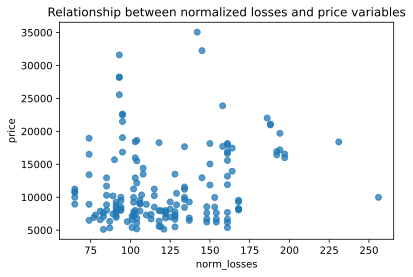

Pearson correlation coefficient: 0.20


In [7]:
tmp = cars[['norm_losses', 'price']]
tmp = tmp.dropna()
tmp = tmp.astype(int)

plt.scatter(tmp['norm_losses'], tmp['price'], alpha=0.75)
plt.xlabel('norm_losses')
plt.ylabel('price')
plt.title('Relationship between normalized losses and price variables')
plt.show()

pearson_r = tmp['norm_losses'].corr(tmp['price'])

print(f'Pearson correlation coefficient: {pearson_r:.2f}')

Эти признаки коррелируют между собой достаточно плохо. В целом, можно заключить, что замена пропущенных значений в столбце `norm_losses` на среднее значение будет однозначно более предпочтительным вариантом, чем удаление 35 рядов.

Однако предварительно необходимо сделать несколько действий. Мы оставим только признаки в числовом выражении, а также разделим датасет на обучающую и тестовую выборки, чтобы избежать data leakage. Если мы этого не сделаем заранее, то данные по среднему значению для столбца `norm_losses` будут посчитаны по всему столбцу и поэтому тестовая выборка получит информацию о данных в обучающей выборке. Кроме того, произведем нормализацию, чтобы числовые данные варьировались в пределах от нуля до единицы. Нормализацию также желательно проводить уже после разделения на обучающую и тестовую выборки.

### 3. Уберем лишние столбцы

В датасете достаточно много признаков, которые можно использовать в качестве независимых переменных. На данном этапе попробуем сделать модель без использования номинативных переменных. Это снизит количество столбцов и сделает датафрейм более удобным для дальнейшей работы. К тому же, 25 фич — это слишком большое количество признаков по сравнению с размером датасета. Так, мы уберем из датафрейма информацию о марке автомобиля, типе топлива, типе кузова, расположении двигателя и т.д., оставив столбцы с характеристиками в числовом выражении. Среди столбцов с числовыми данными есть достаточно много параметров, которые можно использовать в качестве независимых переменных и от которых явно зависит цена автомобиля. Например, это такие характеристики как размер мотора и его мощность, а также размер и масса самого автомобиля.

In [8]:
cars_numeric = cars.drop(columns=[
    'symboling', 'brand', 'fuel', 'aspiration', 'n_doors', 'body', 'drive_wheels', 
    'engine_loc', 'engine_type', 'n_cylinders', 'fuel_system',
]).copy()

cars_numeric.head(10)

,norm_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450
5,NaN,99.8,177.3,66.3,53.1,2507,136,3.19,3.40,8.5,110,5500,19,25,15250
6,158.0,105.8,192.7,71.4,55.7,2844,136,3.19,3.40,8.5,110,5500,19,25,17710
7,NaN,105.8,192.7,71.4,55.7,2954,136,3.19,3.40,8.5,110,5500,19,25,18920
8,158.0,105.8,192.7,71.4,55.9,3086,131,3.13,3.40,8.3,140,5500,17,20,23875
10,192.0,101.2,176.8,64.8,54.3,2395,108,3.50,2.80,8.8,101,5800,23,29,16430


Также имеет смысл удалить из датасета один из столбцов со значениями расхода топлива (`highway_mpg` либо `city_mpg`), так как они обнаруживают сильнейшую корреляцию:

In [9]:
mpg_corr = cars_numeric['highway_mpg'].corr(cars_numeric['city_mpg'])
print(f'Pearson r between highway and city mpgs is {mpg_corr:.2f}')

Pearson r between highway and city mpgs is 0.97


In [10]:
cars_numeric.drop(columns='highway_mpg', inplace=True)
cars_numeric.head()

,norm_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,13495
1,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,16500
2,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,16500
3,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,13950
4,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,17450


### 4. Создание обучающей и тестовой выборок, импутация данных и нормализация

In [11]:
# разделим датафрейм на набор признаков (X) и зависимую переменную (y)
X = cars_numeric.drop(columns='price')
y = cars_numeric['price']

# разделим датафрейм на обучающую и тестовую выборки, сделаем тестовую выборку относительно большой, так как данных мало
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

# заменим пропущенные значения в столбце `norm_losses` на среднее арифметическое для этого столбца
numeric_imp = SimpleImputer()
X_train['norm_losses'] = numeric_imp.fit_transform(X_train[['norm_losses']])
X_test['norm_losses'] = numeric_imp.transform(X_test[['norm_losses']])

# проведем нормализацию значений, чтобы они варьировались от 0 до 1
scaler = MinMaxScaler()
X_train[:] = scaler.fit_transform(X_train)
X_test[:] = scaler.transform(X_test)

X_train.head(10).round(3)

,norm_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg
43,0.311,0.266,0.481,0.132,0.504,0.329,0.189,0.621,0.552,0.094,0.140,0.265,0.324
18,0.293,0.062,0.000,0.000,0.478,0.000,0.000,0.298,0.457,0.156,0.000,0.388,1.000
5,0.311,0.455,0.589,0.526,0.469,0.395,0.283,0.524,0.633,0.094,0.290,0.551,0.176
127,0.311,0.100,0.452,0.412,0.336,0.492,0.502,0.968,0.395,0.156,0.743,0.714,0.118
105,0.675,0.162,0.481,0.667,0.168,0.640,0.453,0.718,0.571,0.050,0.710,0.429,0.118
51,0.204,0.224,0.293,0.342,0.558,0.160,0.113,0.395,0.514,0.125,0.093,0.347,0.529
61,0.335,0.421,0.597,0.544,0.522,0.348,0.230,0.685,0.629,0.100,0.168,0.265,0.382
85,0.314,0.334,0.509,0.447,0.336,0.340,0.230,0.653,0.662,0.094,0.187,0.347,0.353
104,0.675,0.162,0.481,0.667,0.168,0.614,0.453,0.718,0.571,0.125,0.523,0.429,0.176
96,0.298,0.272,0.393,0.307,0.593,0.187,0.136,0.492,0.581,0.150,0.098,0.429,0.529


После удаления стоблцов с номинативными переменными в датафреме осталось 13 фич с числовым типом данных. Убедимся, что в выборках не осталось пропущенных значений:

In [12]:
print(f'Missing values in the train set: \n{X_train.isnull().sum()}')
print(f'Missing values in the test set: \n{X_test.isnull().sum()}')

Missing values in the train set: 
norm_losses          0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_size          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
dtype: int64
Missing values in the test set: 
norm_losses          0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_size          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
dtype: int64


Теперь обучающая и тестовая выборки готовы для построения алгоритма и тестирования моделей.

### 5. Унивариантная модель

#### 5.1 Унивариантные модели с использованием разных признаков при постоянном k = 5

Мы начнем с простой модели, чтобы лучше прочувствовать зависимости в датасете и впоследствии перейти к более сложной модели. Напишем функцию, которая будет обладать следующими характеристиками:

* принимает один параметр — название признака
* создает объект `KNeighborsRegressor` c дефолтными параметрами, производит обучение и предикт
* рассчитывает и возвращает корень из среднеквадратичной ошибки (root mean squared error, RMSE)

In [13]:
def uni_kneighbors(feature_name):
    '''Generates univariate k-nearest neighbors model based on the provided feature.'''    
    X_train_one_f = X_train[feature_name].values.reshape(-1, 1)
    X_test_one_f = X_test[feature_name].values.reshape(-1, 1)
    
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train_one_f, y_train)
    y_pred = knn.predict(X_test_one_f)
    rmse = MSE(y_test, y_pred, squared=False)
    
    return rmse

Далее мы применим функцию последовательно ко всем признакам по отдельности и рассчитаем rmse для каждой модели. Всего у нас 13 признаков, должно получится 13 моделей, которые предсказывают цену автомобиля на основе того или иного признака.

In [14]:
features = list(X_train.columns)

rmse_one_f = {}

for f in features:
    rmse = uni_kneighbors(f)
    rmse_one_f[f] = rmse
    print(f'Root mean squared error using {f} feature is {rmse:.1f}')

Root mean squared error using norm_losses feature is 7667.7
Root mean squared error using wheel_base feature is 6342.2
Root mean squared error using length feature is 5365.5
Root mean squared error using width feature is 5105.0
Root mean squared error using height feature is 7995.9
Root mean squared error using curb_weight feature is 5187.1
Root mean squared error using engine_size feature is 3345.7
Root mean squared error using bore feature is 7156.6
Root mean squared error using stroke feature is 8554.0
Root mean squared error using compression_ratio feature is 6983.9
Root mean squared error using horsepower feature is 4935.3
Root mean squared error using peak_rpm feature is 9631.1
Root mean squared error using city_mpg feature is 5562.6


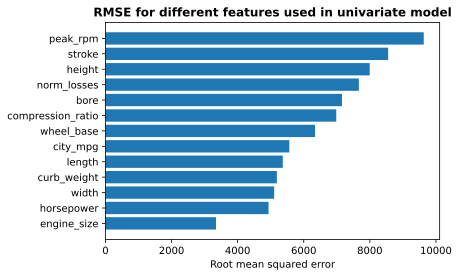

In [15]:
rmse_one_f_sorted = dict(sorted(rmse_one_f.items(), key=lambda item: item[1]))

plt.barh(list(rmse_one_f_sorted.keys()), rmse_one_f_sorted.values())
plt.xlabel('Root mean squared error')
plt.title('RMSE for different features used in univariate model', weight='bold')
plt.show()

Однозначно минимизирует ошибку на тестовой выборе при k = 5 такой признак как размер двигателя (`engine_size`). Примерно одинаково низкая ошибка также получается при использовании следующих признаков:  `horsepower`, `width`, `curb_weight`, `length`, `city_mpg`. Это параметры, отражающие мощность, снаряженную массу (`curb_weight`), ширину автомобиля и расход топлива, что выглядит достаточно логичным. Относительно низкое значение ошибки получено также при использовании параметра `length` (длина автомобиля). При этом высота (`height`) влияет на стоимость уже существенно меньше, что также выглядит абсолютно логичным.

#### 5.2 Унивариантная модель с использованием различных признаков и разных значений k

Далее мы немного модифицируем функцию и добавим возможность расчета ошибки при разных значениях k (число ближайших соседей).

In [16]:
k_values = np.arange(1, 31)

def uni_kneighbors(feature_name):
    '''Generates univariate k-nearest neighbors model based on the provided feature and number of k.'''    
    rmse_values = []
    
    X_train_one_f = X_train[feature_name].values.reshape(-1, 1)
    X_test_one_f = X_test[feature_name].values.reshape(-1, 1)
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_one_f, y_train)
        y_pred = knn.predict(X_test_one_f)
  
        rmse = MSE(y_test, y_pred, squared=False)
        rmse_values.append(rmse)
        
    return rmse_values

Применим получившуюся функцию последовательно ко всем признакам:

In [17]:
rmse_one_f_different_k = {}

for f in features:
    rmse_values = uni_kneighbors(f)
    rmse_one_f_different_k[f] = rmse_values
    
rmse_one_f_different_k

{'norm_losses': [10987.55981299159,
  9687.946340073091,
  7945.618805093589,
  8081.5682507759075,
  7667.709329742732,
  7418.12162942516,
  7596.838002697253,
  7685.898533962337,
  7737.088662969852,
  7777.420128732507,
  7966.89754119213,
  8067.962983421509,
  7912.891510678845,
  8035.0459449642185,
  8059.5088909460965,
  8006.278492925192,
  7753.943401325022,
  7694.932913863486,
  7807.567884296614,
  7777.776687242324,
  7735.988012511931,
  7745.441113153605,
  7679.509375528005,
  7720.8675946874755,
  7766.956303129651,
  7848.051262333345,
  7976.146474295085,
  8079.145102878873,
  8138.496431266183,
  8193.988479538279],
 'wheel_base': [4857.525287145116,
  5919.190935108546,
  5644.201991638017,
  5953.555269983998,
  6342.233980845915,
  6337.522150271265,
  6385.648378575551,
  6572.5333554841145,
  6594.724894028088,
  6649.999992723334,
  6740.233293854303,
  6683.452374603787,
  6725.422826414915,
  6793.621130843229,
  6914.518454745561,
  6952.146972274074,
 

Получилось достаточно много комбинаций типа "признак-значение параметра k". Провести интерпретацию будет гораздо проще, если визуализировать данные на графике:

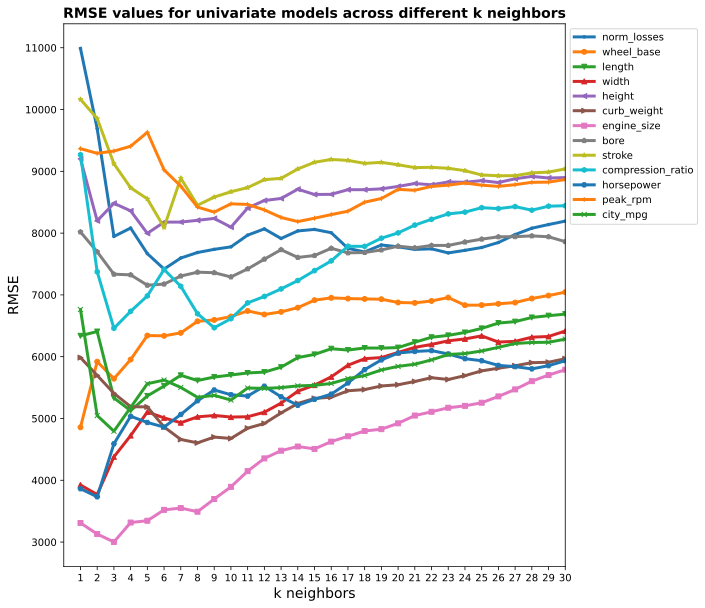

In [18]:
markers = [".","o","v","^","<",">","s","p","*","h","H","+","x","d","|","_"]

plt.figure(figsize=(9, 10))
i=0

for f, value in rmse_one_f_different_k.items():
    plt.plot(k_values, value, label=f, linewidth=3, marker=markers[i], markersize=5)
    i += 1

plt.title('RMSE values for univariate models across different k neighbors', fontsize=14, weight='bold')
plt.xlabel('k neighbors', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.xlim(0, 16)
plt.xticks(np.arange(1, 31))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [19]:
min_rmse = min(rmse_one_f_different_k['engine_size'])
print(f'Min RMSE value {min_rmse:.1f} is for the `engine_size` feature with k = 3')

Min RMSE value 3002.1 is for the `engine_size` feature with k = 3


Из всех возможных комбинаций признаков и количества ближайших соседей в диапазоне от 1 до 30, наименьшее значение корня из среднеквадратичной ошибки имеют предсказания модели, которая обучена на признаке `engine_size` (мощность двигателя в л.с.) при k = 3. Признаки, которые хорошо себя зарекомендовали в построении модели при постоянном k, также хорошо проявляют себя при других значениях k. Это такие характеристики автомобиля как `horsepower`, `width`, `curb_weight`, `city_mpg`, `length`. Очевидно, что именно их нужно использовать в модели с несколькими предикторами. Также неплохо здесь проявил себя признак `wheel_base`, хотя и только при k = 1 (при более высоких значениях k ошибка существенно возрастает). 

Отметим, однако, что в большинстве случаев обученные модели имеют высокую ошибку при k = 1, которая затем снижается в диапазоне k от 2 до 5 (в большинстве случаев) и иногда при более высоких значениях k. Алгоритм KNN при k = 1 имеет максимальную сложность, и, таким образом, модель переобучается, что приводит к высоким ошибкам на тестовой выборке. Добавление количества ближаших соседей позволяет снизить эффект переобучения.

### 6. Модель с несколькими предикторами

Теперь попробуем обучить модели с использованием нескольких независимых переменных, при этом будем варьировать как число предикторов, так и значение k.

In [20]:
def multi_kneighbors(feature_names):
    '''Generates multivariate k-nearest neighbors model based on the provided features and k amount.'''
    rmse_values = []
    
    X_train_multi_f = X_train[feature_names]
    X_test_multi_f = X_test[feature_names]  
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_multi_f, y_train)
        y_pred = knn.predict(X_test_multi_f)
  
        rmse = MSE(y_test, y_pred, squared=False)
        rmse_values.append(rmse)
        
    return rmse_values

Создадим ряд комбинаций признаков в порядке того, насколько хорошо они проявили себя при создании моделей на основе одного предиктора:

Min RMSE value for ['engine_size', 'horsepower'] features is 2998.8
Min RMSE value for ['engine_size', 'horsepower', 'width'] features is 2779.8
Min RMSE value for ['engine_size', 'horsepower', 'width', 'curb_weight'] features is 2838.1
Min RMSE value for ['engine_size', 'horsepower', 'width', 'curb_weight', 'city_mpg'] features is 2820.8
Min RMSE value for ['engine_size', 'horsepower', 'width', 'curb_weight', 'city_mpg', 'wheel_base'] features is 3377.4
Min RMSE value for ['engine_size', 'horsepower', 'width', 'curb_weight', 'city_mpg', 'wheel_base', 'length'] features is 3341.4


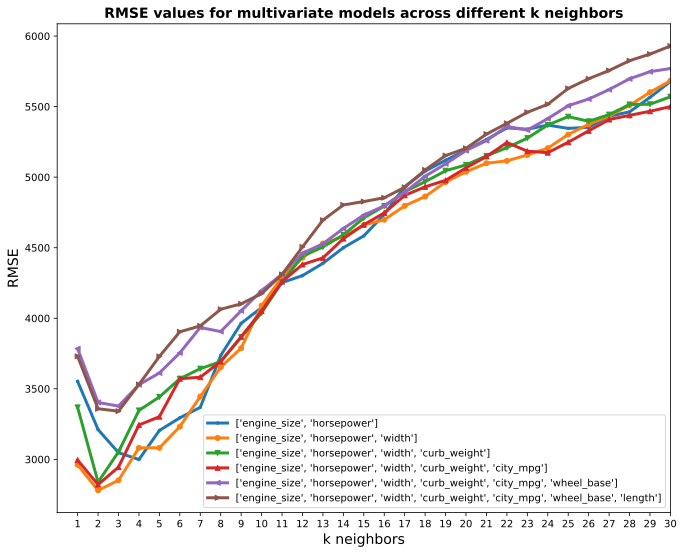

In [21]:
two_best_features = ['engine_size', 'horsepower']
three_best_features = ['engine_size', 'horsepower', 'width']
four_best_features = ['engine_size', 'horsepower', 'width', 'curb_weight']
five_best_features = ['engine_size', 'horsepower', 'width', 'curb_weight', 'city_mpg']
six_best_features = ['engine_size', 'horsepower', 'width', 'curb_weight', 'city_mpg', 'wheel_base']
seven_best_features = ['engine_size', 'horsepower', 'width', 'curb_weight', 'city_mpg', 'wheel_base', 'length']

best_features = [
    two_best_features, 
    three_best_features, 
    four_best_features, 
    five_best_features,
    six_best_features,
    seven_best_features
]

plt.figure(figsize=(11, 9))

for i, f in enumerate(best_features):
    rmse_multi_f = multi_kneighbors(f)
    plt.plot(k_values, rmse_multi_f, label=f, linewidth=3, marker=markers[i], markersize=5)   
    print(f'Min RMSE value for {f} features is {np.min(rmse_multi_f):.1f}')

plt.title('RMSE values for multivariate models across different k neighbors', fontsize=14, weight='bold')
plt.xlabel('k neighbors', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.xlim(0, 16)
plt.xticks(range(1, 31))    
plt.legend()
plt.show()    

Использование комбинаций из различных предикторов приводит к снижению ошибки на тестовой выборке.

Наименьшая ошибка получена при использовании трех признаков (`engine_size`, `horsepower`, `width`) при k = 2. Добавление других фич и увеличение параметра k приводит к увелечению ошибки, хотя варианты с четырьмя (+ `curb_weight`) и пятью признаками (+ `curb_weight`, + `city_mpg`) имеют ошибку лишь ненамного выше при k = 2. По видимому, здесь большую роль играет то, как именно наш небольшой датасет был разбит на обучающую и тестовую выборки.

Теперь попробуем построить модель при различных k, используя все 13 доступных фич.

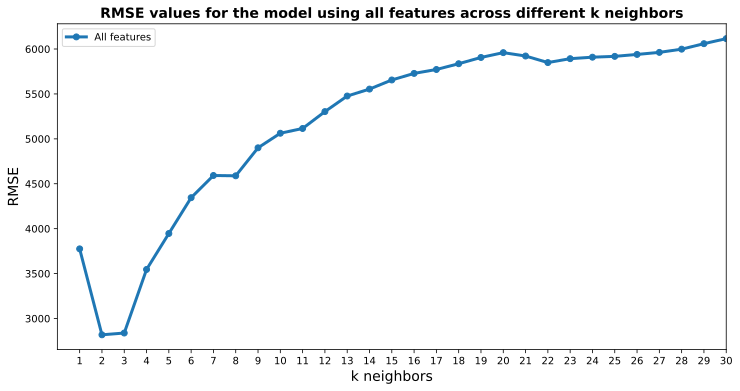

Min RMSE value for all numeric features is 2818.3


In [22]:
rmse_all_features = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)    
    rmse = MSE(y_test, y_pred, squared=False)
    rmse_all_features.append(rmse)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 31), rmse_all_features, label='All features', linewidth=3, marker='o')
plt.title('RMSE values for the model using all features across different k neighbors', fontsize=14, weight='bold')
plt.xlabel('k neighbors', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.xlim(0, 16)
plt.xticks(np.arange(1, 31))
plt.legend()
plt.show()

print(f'Min RMSE value for all numeric features is {np.min(rmse_all_features):.1f}')

Здесь также наблюдается характерный минимум при k = 2 и k = 3. Интересно, что все тринадцать фич показали неплохой результат (rmse = 2818.3) при k = 2, хотя и немного хуже, чем при использовании трех признаков `engine_size`, `horsepower`, `width` (rmse = 2779.8).

### 7. Кросс-валидация

Хотя мы уже построили модели для разных комбинаций признаков и числа ближайших соседей, мы можем дополнительно обучить модели на некоторых вариациях обучающей выборки с использованием некоторой небольшой части обучающей выборки для расчета метрики.



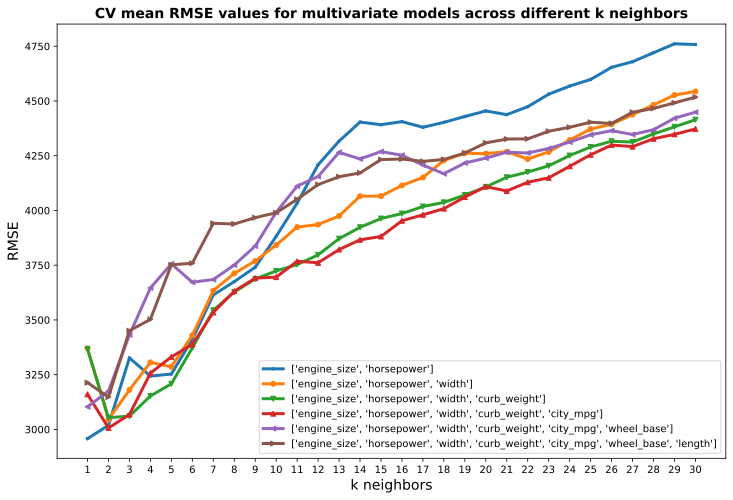

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
  
plt.figure(figsize=(12, 8))    
    
for i, f in enumerate(best_features):
    
    cv_scores_lst = []
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        cv_scores = - cross_val_score(knn, X_train[f], y_train, 
                                      cv=kf, scoring='neg_root_mean_squared_error')
        mean_cv_score = np.mean(cv_scores)
        cv_scores_lst.append(mean_cv_score)
       
    plt.plot(k_values, cv_scores_lst, label=f, linewidth=3, marker=markers[i], markersize=5)
    
plt.title('CV mean RMSE values for multivariate models across different k neighbors', 
          fontsize=14, weight='bold')
plt.xlabel('k neighbors', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.xticks(np.arange(1, 31))
plt.legend()
plt.show()

Здесь также видно, что ошибка минимизируется при небольших значениях k = 2 и k = 1. В двух из шести случаев лучший результат получен при k = 1. Однако проверка таких моделей на более объемной тестовой выборкe показала, что такие модели являются переобученными и существенно лучше ведут себя при более высоком параметре k. 

Данные по кросс-валидации показывают, что лучшие результаты получаются при использовании k = 2 и трех фич (`engine_size`, `horsepower`, `width`), к которым можно добавлять `curb_weight` и `city_mpg`. Это соответствует тому результату, что мы получили при обучении моделей на всей тестовой выборке и предикту на тестовой ранее.

### 8. Некоторые инсайты из кривых обучения (learning curves)

Для примера, ниже мы построим два графика (для трех и четырех признаков), в которых сравним ошибки, получаемые при предикте с использованием тестовой и обучающей выборок. Очевидно, что на обучающей выборке ошибки будут меньше, но нас интересует, насколько они будут выше на тестовой. Как известно, сильные различия между значениями ошибок на обучающей и тестовой выборках указывают на переобучение модели.

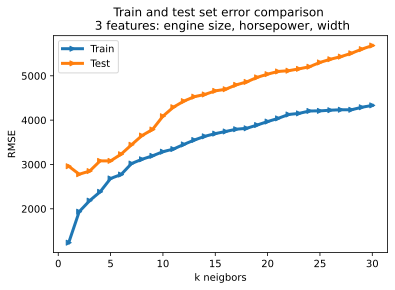

In [24]:
rmse_train = []
    
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train[['engine_size', 'horsepower', 'width']], y_train)
    y_pred = knn.predict(X_train[['engine_size', 'horsepower', 'width']])
    rmse = MSE(y_train, y_pred, squared=False)
    rmse_train.append(rmse)

plt.plot(k_values, rmse_train , linewidth=3, marker=markers[i], markersize=5, label='Train')    
    
rmse_test = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train[['engine_size', 'horsepower', 'width']], y_train)
    y_pred = knn.predict(X_test[['engine_size', 'horsepower', 'width']])
    rmse = MSE(y_test, y_pred, squared=False)
    rmse_test.append(rmse)

plt.plot(k_values, rmse_test, linewidth=3, marker=markers[i], markersize=5, label='Test')    
plt.title('Train and test set error comparison \n 3 features: engine size, horsepower, width')
plt.xlabel('k neigbors')
plt.ylabel('RMSE')
plt.legend()

plt.show()

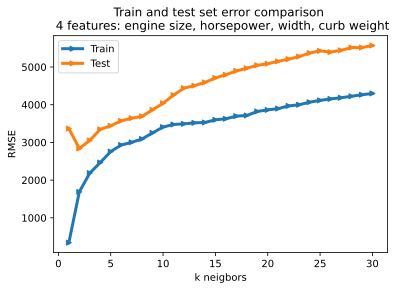

In [25]:
rmse_train = []
    
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train[['engine_size', 'horsepower', 'width', 'curb_weight']], y_train)
    y_pred = knn.predict(X_train[['engine_size', 'horsepower', 'width', 'curb_weight']])
    rmse = MSE(y_train, y_pred, squared=False)
    rmse_train.append(rmse)

plt.plot(k_values, rmse_train , linewidth=3, marker=markers[i], markersize=5, label='Train')

rmse_test = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train[['engine_size', 'horsepower', 'width', 'curb_weight']], y_train)
    y_pred = knn.predict(X_test[['engine_size', 'horsepower', 'width', 'curb_weight']])
    rmse = MSE(y_test, y_pred, squared=False)
    rmse_test.append(rmse)

plt.plot(k_values, rmse_test, linewidth=3, marker=markers[i], markersize=5, label='Test')
plt.title('Train and test set error comparison \n 4 features: engine size, horsepower, width, curb weight')
plt.xlabel('k neigbors')
plt.ylabel('RMSE')
plt.legend()

plt.show()

Полученные графики представляют собой типичные learning curves для алгоритма KNN, которые изначально находятся далеко друг от друга, но сходятся друг к другу при увеличении числа k. Данные графики дополнительно свидетельствуют о том, что умеренное увеличение параметра k приводит к упрощению модели и снижению эффекта переобучения. Оптимальным параметром в нашей ситуации можно считать k = 2, так как при этом значении кривые обнаруживают сильную сходимость, а далее ошибки на обеих выборках только растут.

## Заключение

В рамках реализации данного проекта мы использовали метод k-ближайших соседей для прогнозирования стоимости автомобилей на основе их характеристик.

Основные выводы из проекта следующие:

* Наиболее ценными количественными признаками, которые можно использовать для прогнозирования цены автомобиля, являются объем мотора, мощность в лошадиных силах, ширина, снаряженная масса (эти четыре признака положительно коррелируют со стоимостью) и расход топлива (отрицательно коррелирует со стоимость). По-видимому, в зависимости от того, как именно данные будут разбиты на выборки, "лучшая" комбинация признаков также может варьировать. В ходе данного проекта наименьшую ошибку на тестовой выборке удалось получить при использовании трех фич, таких как объем мотора, мощность в л.с. и ширина автомобиля; добавление к ним дополнительных признаков из числа оптимальных приводит примерно к такому же результату.

* Увеличение числа ближайших соседей (параметр k) ведет к упрощению модели и, как правило, к увеличению ошибки на тестовой выборке, особенно для достаточно больших значений k (более 5, иногда более 10). В то же время, избыточно сложная модель с минимальным количеством ближайших соседей (k = 1) приводит к переобучению. В данном случае оптимальное число соседей для разных комбинаций фич варьировало от 2 до 3. Лучший результат получен при k = 2 для трех признаков.

* Небольшой датасет предъявляет особые требования к подготовке данных и обучению модели. В ходе чистки данных нужно сохранить как можно больше рядов, при обучении желательно использовать более объемную тестовую выборку. Маленькая тестовая выборка не позволит оценить качество модели; в то же время слишком большая тестовая выборка оставит мало данных в и так небольшом датасете для обучения. Небольшой датасет также имеет высокий элемент рандомизации, позволяя уловить общие тренды, однако не позволяя настраивать модель более тонко.